## 0. Utils

In [52]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

RANDOM_STATE = 42

def prepare_related_data(columns: list, index_column: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Related data will be processed in the same way:
    - group by `index_column`
    - sum all columns
    - apply log1p to all columns except `index_column`
    """
    col_to_fetch = columns + [index_column]
    res = df[col_to_fetch].groupby(index_column).sum()
    res = res[columns].apply(np.log1p)
    return res


def prepare_data(train: pd.DataFrame, dpi: pd.DataFrame, bnum: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare data for training
    """
    dpi_columns = ['SUM_of_Duration_sec','SUM_of_Volume_kb','SUM_of_Count_events','MAX_of_day_cnt']
    dpi_index_column = 'abon_id'

    bnum_columns = ['call_cnt_out','call_cnt_in','call_dur_out','call_dur_in','cnt_sms_out','cnt_sms_in']
    bnum_index_column = 'abon_id'

    df_train_dpi_agg = prepare_related_data(dpi_columns, dpi_index_column, dpi)
    df_train_bnum_agg = prepare_related_data(bnum_columns, bnum_index_column, bnum)
    # let's merge all dataframes
    # merge bnum dataframe
    df_train = train.merge(df_train_bnum_agg, on='abon_id', how='left')

    # merge dpi dataframe
    df_train = df_train.merge(df_train_dpi_agg, on='abon_id', how='left')

    # fill missings for dpi_columns, bnum_columns
    df_train.fillna({col: df_train[col].median() for col in dpi_columns + bnum_columns}, inplace=True)
    return df_train


# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)


def get_score(df_train: pd.DataFrame, target_column: str = 'target') -> float:
    """
    Get score for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    return score_dataset(X_train, X_val, y_train, y_val)


def get_feature_importance(df_train: pd.DataFrame =  None, target_column: str = 'target', estimator=RandomForestRegressor) -> pd.DataFrame:
    """
    Get feature importance for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    return estimate_feature_importance(X, y, estimator)


def estimate_feature_importance(X, y, estimator) -> pd.DataFrame:
    model = estimator(random_state=RANDOM_STATE)
    model.fit(X, y)
    return pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)


def drop_columns_with_nulls(frame: pd.DataFrame, threshold: float = 0.7) -> pd.DataFrame:
    """
    Drop columns with more than threshold % of nulls
    """
    return frame.dropna(thresh=threshold*frame.shape[0], axis=1)


def impute_dataset(X, y) -> pd.DataFrame:
    """
    Impute dataset
    """
    simple_impute = SimpleImputer(missing_values=np.nan, add_indicator=True, strategy='constant', fill_value=0)
    imputed = simple_impute.fit_transform(X, y)
    # Extract the indicator columns
    indicator = simple_impute.indicator_
    indicator_columns = indicator.get_feature_names_out(input_features=X.columns)
    # Reconstruct the DataFrame with the original columns and indicator columns
    new_columns = list(X.columns) + list(indicator_columns)
    return pd.DataFrame(imputed, columns=new_columns, index=X.index)



## Dataset scoring

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

def prepare_related_data(columns: list, index_column: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Related data will be processed in the same way:
    - group by `index_column`
    - sum all columns
    - apply log1p to all columns except `index_column`
    """
    col_to_fetch = columns + [index_column]
    res = df[col_to_fetch].groupby(index_column).sum()
    res = res[columns].apply(np.log1p)
    return res


# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)


def get_score(df_train: pd.DataFrame, target_column: str = 'target') -> float:
    """
    Get score for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

    return score_dataset(X_train, X_val, y_train, y_val)


def get_feature_importance(df_train: pd.DataFrame =  None, target_column: str = 'target', estimator=RandomForestRegressor) -> pd.DataFrame:
    """
    Get feature importance for the given dataframes
    """
    acopy = df_train.copy()
    X, y = acopy.drop(target_column, axis=1), acopy[target_column]
    return estimate_feature_importance(X, y, estimator)


def estimate_feature_importance(X, y, estimator) -> pd.DataFrame:
    model = estimator(random_state=RANDOM_STATE)
    model.fit(X, y)
    return pd.DataFrame(data=model.feature_importances_, index=X.columns, columns=['importance']).sort_values(by='importance', ascending=False)

def scale_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Scale features
    """
    # return X
    
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)


def prepare_dataset(train: pd.DataFrame, dpi: pd.DataFrame, bnum: pd.DataFrame, features: list[str] | None = None, columns_to_drop: list[str] | None = None) -> tuple[pd.DataFrame, pd.Series]:
    """
    Prepare dataset for training
    """
    dataset = prepare_data(train, dpi, bnum)
    scaler = StandardScaler()
    # drop columns
    dataset =  dataset.drop(columns=columns_to_drop) if columns_to_drop else dataset
    if features:
        # if features are provided, we will use only them
        X, y = dataset.drop('target', axis=1), dataset['target']
        X = impute_dataset(X, y)
        X = X[features]

#         pca = PCA(n_components=2)
#         pca_result = pca.fit_transform(scaled_data)
        return X, y
    else:
        df_train_nulls_removed = drop_columns_with_nulls(dataset)
        X, y = df_train_nulls_removed.drop('target', axis=1), df_train_nulls_removed['target']
        X = impute_dataset(X, y)

#         X_scaled = scale_features(X_imputed)
#         pca = PCA(n_components=2)
#         pca_result = pca.fit_transform(scaled_data)
        return X, y

## FEATURE SELECTION

# SK learn FEATURE selection 

from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.inspection import permutation_importance
# ligtgbm features
import lightgbm as lgb
import xgboost as xgb
from functools  import partial


# model parameters tuning
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.searchcv import BayesSearchCV


def get_low_variance_features(X: pd.DataFrame, y:  pd.Series, threshold: float = 0.8, **kwargs) -> pd.DataFrame:
    """
    Get features with low variance
    """
    sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
    sel.fit_transform(X, y)
    return X.columns[sel.get_support(indices=True)].to_list()


# using KBEST
def get_k_best_features(X: pd.DataFrame, y: pd.Series, k: int = 200, **kwargs) -> pd.DataFrame:
    """
    Get K best features
    """
    selection_method = SelectKBest(f_classif, k=k)
    selection_method.fit_transform(X, y)
    return X.columns[selection_method.get_support(indices=True)].to_list()


# select from model
def get_features_from_model(X: pd.DataFrame, y: pd.Series, **kwargs) -> list[str]:
    """
    Get features from model
    """

    model = SelectFromModel(
        estimator=ExtraTreesClassifier(n_estimators=50).fit(X, y), 
        prefit=True
    )
    model.transform(X)
    return X.columns[model.get_support(indices=True)].to_list()


def get_xgboos_features(X: pd.DataFrame, y: pd.Series, threshold: float=0.0018, **kwargs) -> list[str]:
    """
    Get features from using XGBoost
    """

    model = partial(xgb.XGBModel, objective='binary:logistic') 
    features = estimate_feature_importance(X, y, model)
    return features.abs()[features.importance>threshold].index.tolist()


def get_lgbm_features(X: pd.DataFrame, y: pd.Series, importance_type: str = 'gain', importance=3, lgbm_kwargs: dict | None = None, **kwargs) -> list[str]:
    """
    Get features from using LightGBM
    """
    lgb_features = estimate_feature_importance(X, y, partial(lgb.LGBMClassifier, importance_type=importance_type, **(lgbm_kwargs or {})))

    return lgb_features[lgb_features.importance > importance].index.to_list()

def get_catboost_features(X: pd.DataFrame, y: pd.Series, importance: int =0.1, cat_kwargs: dict | None = None, **kwargs) -> list[str]:
    """
    Get features from using CatBoost
    """

    cat_features = estimate_feature_importance(X, y, partial(CatBoostClassifier, verbose=False, **(cat_kwargs or {})))

    return cat_features[cat_features.importance > importance].index.to_list()

def get_correlation_features(X: pd.DataFrame, y: pd.Series,  threshold=0.1, **kwargs) -> list[str]:
    """
    Get features from using correlation
    """
    corr = X.corrwith(y)
    
    return corr[abs(corr) > threshold].index.to_list()


def get_rfe_features(X: pd.DataFrame, y: pd.Series, n_features_to_select=200, **kwargs) -> list[str]:
    """
    Get features from using RFE
    """
    from sklearn.feature_selection import RFE
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_features_to_select, verbose=1)
    rfe.fit(X, y)
    return X.columns[rfe.support_].to_list()

def get_features_mars_model(X: pd.DataFrame, y: pd.Series, **kwargs) -> list[str]:
    """
    Get features from using MARS model
    """
    from pyearth import Earth
    model = Earth()
    model.fit(X, y)
    # sort by importance
    

    return X.columns[model.feature_importances_ > 0.01].to_list()




def get_features_by_permutation(X: pd.DataFrame, y: pd.Series, X_val:  pd.DataFrame, y_val: pd.DataFrame) -> list[str]:
    # feature permutation
    model =  lgb.LGBMClassifier(random_state=RANDOM_STATE)

    lgbm_features  = get_lgbm_features(55)

    X_test_lgbm = X_val[lgbm_features]
    X_train_lgbm = X[lgbm_features]

    _, X_test, _, y_test = train_test_split(X_test_lgbm, y_val, test_size=0.2)

    model.fit(X_train_lgbm, y)
    r = permutation_importance(model, X_test, y_test,
                            n_repeats=30,
                            random_state=0)
    res  = {}
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{X_train_lgbm.columns[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
            res[X_train_lgbm.columns[i]]  = r.importances_mean[i]


def find_params_xgboost(X: pd.DataFrame, y: pd.DataFrame, eval_metric='auc', **kwargs) -> BayesSearchCV:
    xgb_search_space  = {
        'n_estimators': Integer(50, 1000),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'max_depth': Integer(3, 10),
        'min_child_weight': Integer(1, 10),
        'gamma': Real(0, 0.5),
        'subsample': Real(0.6, 1.0, prior='uniform'),
        'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
        'reg_alpha': Real(0.01, 1.0, prior='log-uniform'),
        'reg_lambda': Real(0.01, 1.0, prior='log-uniform'),
        'scale_pos_weight': Real(1.0, 10.0, prior='uniform')
    }
    xgb_bayes_cv = BayesSearchCV(
        estimator=xgb.XGBClassifier(
            use_label_encoder=False, random_state=RANDOM_STATE,
            **kwargs,
            **(dict(eval_metric=eval_metric) if eval_metric else {})
        ),
        search_spaces=xgb_search_space,
        n_iter=32,
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
    xgb_bayes_cv.fit(X, y)
    return xgb_bayes_cv


def find_params_rfc(X: pd.DataFrame, y: pd.DataFrame) -> BayesSearchCV:
    rf_search_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'bootstrap': [True, False]
    }
    rf_bayes_cv = BayesSearchCV(
        estimator=RandomForestClassifier(random_state=RANDOM_STATE, criterion='gini'),
        search_spaces=rf_search_space,
        n_iter=32,
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
    rf_bayes_cv.fit(X, y)
    return rf_bayes_cv


def find_params_lgbmc(X: pd.DataFrame, y: pd.DataFrame, metric: str|None = None, lgbmc_kwargs: dict | None = None) -> BayesSearchCV:
    lgbm_search_space  = {
        # 'num_leaves': Integer(31, 150),
        # 'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        # 'n_estimators': Integer(100, 1000),
        # 'max_depth': Integer(-1, 20),
        # 'min_child_samples': Integer(10, 100),
        # 'subsample': Real(0.6, 1.0, prior='uniform'),
        # 'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
        'reg_alpha': Real(0.0, 1.0, prior='uniform'),
        'reg_lambda': Real(0.0, 1.0, prior='uniform')
    }
    lgbm_bayes_cv = BayesSearchCV(
        estimator=lgb.LGBMClassifier(
            objective='binary',
            random_state=RANDOM_STATE, 
            verbose=-1,
            **(dict(metric=metric) if metric else {}),
            **(lgbmc_kwargs if lgbmc_kwargs else {})
        ),
        search_spaces=lgbm_search_space,
        n_iter=32,
        cv=3,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE
    )
    lgbm_bayes_cv.fit(X, y)
    return lgbm_bayes_cv



### Features set scoring
# let's implement   a  function for validation of  model

from collections import defaultdict
from sklearn.metrics import f1_score, log_loss, precision_score, recall_score, roc_auc_score, auc
from sklearn.model_selection import cross_validate
import typing as t
from collections import Counter

from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score


# Define the scoring metrics
def estimate_feature_set(model, X: pd.DataFrame, y: pd.Series, feature_set: t.Iterable | None = None ) -> dict:
    """
    Score feature set
    """
    X_features = X[list(feature_set)] if feature_set else X

    scoring = {
        'precision': make_scorer(precision_score, average='macro'),
        'recall': make_scorer(recall_score, average='macro'),
        'f1': make_scorer(f1_score, average='macro')
    }
    

    # Perform cross-validation
    scores = cross_validate(model, X_features, y, cv=5,  scoring=scoring, return_train_score=True)

    precision_scores = scores['test_precision']
    recall_scores = scores['test_recall']
    f1_scores = scores['test_f1']

    print(f'Model: {model.__class__.__name__}: Accuracy scores: {precision_scores.mean()} \tRecall scores: {recall_scores.mean()}\tF1 scores: {f1_scores.mean()}')
    return scores   

def score_feature_set(model, X: pd.DataFrame, y: pd.Series, feature_set: t.Iterable | None = None ) -> dict:
    """
    Score feature set
    """
    X_features = X[list(feature_set)] if feature_set else X

    scoring = {
        'precision': make_scorer(precision_score, average='macro'),
        'recall': make_scorer(recall_score, average='macro'),
        'f1': make_scorer(f1_score, average='macro')
    }
    

    # Perform cross-validation
    scores = cross_validate(model, X_features, y, cv=5,  scoring=scoring, return_train_score=True)

    precision_scores = scores['test_precision']
    recall_scores = scores['test_recall']
    f1_scores = scores['test_f1']

    print(f'Model: {model.__class__.__name__}: Accuracy scores: {precision_scores.mean()} \tRecall scores: {recall_scores.mean()}\tF1 scores: {f1_scores.mean()}')
    return scores


def select_best_feature_set(
        X: pd.DataFrame,
        y: pd.Series,
        estimators: list, 
        feature_sets: dict, 
        column_limit: int = 274, 
        default_set: str | None = None,
    ) -> None:

    always_include = feature_sets[default_set] if default_set else set()

    model_max = {}
    SCORES = defaultdict(dict)
    
    for model in estimators:
        for ds_name, columns in feature_sets.items():
            columns_ = columns[:column_limit] if len(columns) > column_limit else columns
            print(f'Dataset: {ds_name}', end='\t')
            SCORES[model][ds_name] = score_feature_set(model,  X, y.astype(int), set(columns_).union(always_include))


    ds_counter = Counter()
    for model, metrics in SCORES.items():
        model_name = model.__class__.__name__
        print(f'For Model: {model_name}  winner is:  ', end='\t')
        # ds scorring
        score_to_dict = {tuple([v.mean() for k,v in scores.items() if k in {'test_precision','test_recall','test_f1'}]): ds for ds, scores in metrics.items()}
        max_mean = max(score_to_dict.keys())
        print(f'{score_to_dict[max_mean]} with score: {max_mean}')
        ds_counter[score_to_dict[max_mean]] += 1
        model_max[model_name] = max_mean
    print(f'Dataset Winner is: {ds_counter.most_common()[0]}\nModel winner is: {max(model_max, key=model_max.get)}')


## MODEL ESTIMATION

# MAke predictions
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_model(model, X: pd.DataFrame, y: pd.Series, threshold: float = 0.5, y_val: pd.Series = None, X_val: pd.DataFrame =None, is_train = False) -> None:
    """
    Evaluate model
    """
    # preds = model.predict(X)
    preds = model.predict_proba(X)[:, 1]

    # Use the default threshold (0.5)

    preds = (preds >= threshold).astype(int)
    print(f'Accuracy: {accuracy_score(y, preds)}')
    print(f'F1: {f1_score(y, preds)}')
    print(f'Precision: {precision_score(y, preds)}')
    print(f'Recall: {recall_score(y, preds)}')
    print(f'ROC AUC: {roc_auc_score(y, preds)}')

    auc_score = roc_auc_score(y, model.predict_proba(X)[:,1])
    cm = confusion_matrix(y, preds, labels=model.classes_)
    print(f'AUC: {auc_score}')
    print(f'Classification Report: {classification_report(y, preds, target_names=["not churn", "churn"])}')
    print(f'ROC Curve: {roc_curve(y, preds)}')

    # plot roc

    # Plot ROC curve
    
    fpr_train, tpr_train, _ = roc_curve(y, model.predict_proba(X)[:, 1])
    auc_train = auc(fpr_train, tpr_train)

    # Calculate ROC curve and AUC for validation set
    fpr_val, tpr_val, _ = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    auc_val = auc(fpr_val, tpr_val)

    # Plot ROC curves
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (area = {auc_train:.3f})')
    plt.plot(fpr_val, tpr_val, color='red', lw=2, label=f'Validation ROC curve (area = {auc_val:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model.__class__.__name__}')
    plt.legend(loc="lower right")


    
    # Plot confusion matrix

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    if is_train:
        binary_classification_metrics(y, preds, y_val, model.predict(X_val), report=True)

    # ConfusionMatrixDisplay(confusion_matrix(y, preds)).plot()


def cap_outliers_to_normal_bounds(df):
    """
    Transform outliers in the DataFrame to be within the boundaries of a normal distribution.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with numerical features.
    
    Returns:
    pd.DataFrame: A DataFrame with outliers capped within normal boundaries.
    """
    df_capped = df.copy()
    
    for column in df_capped.select_dtypes(include=[np.number]).columns:
        Q1 = df_capped[column].quantile(0.25)
        Q3 = df_capped[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap the outliers
        df_capped[column] = np.where(df_capped[column] < lower_bound, lower_bound, df_capped[column])
        df_capped[column] = np.where(df_capped[column] > upper_bound, upper_bound, df_capped[column])
    
    return df_capped

def get_continuous(df, variance_threshold=25) -> list[str]:
    cals_continuous = df.columns[df.nunique() > variance_threshold]
    return cals_continuous.to_list()

def _get_feature_with_high_singular_value_content(df: pd.DataFrame, threshold: float = 0.9, plot: bool = False) -> pd.Series:
    most_frequent_entry =  df.mode()
    df_freq  = df.eq(most_frequent_entry.iloc[0], axis=1)
    df_freq_ = df_freq.mean()
    with_threshold = df_freq_[df_freq_ > threshold]
    if plot:
        with_threshold.sort_values(ascending=False).head(100).plot(kind='bar', figsize=(20, 4))
        plt.title('Top Features with Highest Ratio of Singular Value Content')
        plt.ylabel('Frequency Ratio')
        plt.xlabel('Features')
        plt.show()
    return with_threshold.index.to_list()

def get_high_variance(df, ratio=0.9) -> list[str]:
    high_single_ratio = _get_feature_with_high_singular_value_content(df, ratio)
    return list(set(df.columns) - set(high_single_ratio))

def get_skewed(df) -> list[str]:
    # Calculate skewness for each feature
    skewness = df.skew()
    return skewness[(skewness > 1) | (skewness < -1)].index.to_list()


def scale_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Scale features
    """
    # return X
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

def get_one_hot(df):
    maxes = df.max()
    return  maxes[(maxes <= 1) & (maxes >= 0)].index.to_list()
    
    

def prepare_features(df):
    """
    Only column manipulations (no  rows affected)
    """
    hv_features = get_high_variance(df)
    # apply capp
    df_cap = cap_outliers_to_normal_bounds(df[hv_features])
    continuous_features = get_continuous(df_cap)
    
    skewed_features = get_skewed(df_cap[continuous_features])
    normal_features = list(set(continuous_features) - set(skewed_features))
    non_continuous_features = list(set(hv_features) - set(continuous_features))

    one_hot_fetures = get_one_hot(df_cap[non_continuous_features])
    ordinal_features =  list(set(non_continuous_features) - set(one_hot_fetures))
    
    # apply log1p for skewed
    skewed = df_cap[skewed_features].apply(np.log1p)
    # apply scaler for normal
    normal = scale_features(df_cap[normal_features])
    ordinal = scale_features(df_cap[ordinal_features])
    one_hot = df_cap[one_hot_fetures]
    return pd.concat([skewed, normal, ordinal, one_hot], axis=1)


def binary_classification_metrics(y_true_tr, y_pred_tr, y_true_val = None, y_pred_val = None, report = False):
    print ("{:<15} {:<10} {:<10} {:<10}".format('Metrics','Train','Test','\u0394'))
    metrics_dict = {}

    metrics_dict['roc_auc'] = np.round(roc_auc_score(y_true_tr, y_pred_tr),4)
    metrics_dict['accuracy'] = np.round(accuracy_score(y_true_tr, y_pred_tr),4)
    metrics_dict['precision'] = np.round(precision_score(y_true_tr, y_pred_tr),4)
    metrics_dict['recall'] = np.round(recall_score(y_true_tr, y_pred_tr),4)
    metrics_dict['f1_score'] = np.round(f1_score(y_true_tr, y_pred_tr),4)
    
    if y_true_val is not None:
        metrics_dict_test = {}
        metrics_dict_test['roc_auc'] = np.round(roc_auc_score(y_true_val, y_pred_val),4)
        metrics_dict_test['accuracy'] = np.round(accuracy_score(y_true_val, y_pred_val),4)
        metrics_dict_test['precision'] = np.round(precision_score(y_true_val, y_pred_val),4)
        metrics_dict_test['recall'] = np.round(recall_score(y_true_val, y_pred_val),4)
        metrics_dict_test['f1_score'] = np.round(f1_score(y_true_val, y_pred_val),4)
        # print(classification_report(y_true_val, y_pred_val))
    
        for metrics, value in metrics_dict.items():
            value_test = metrics_dict_test[metrics]
            diff = np.round(metrics_dict_test[metrics] - value, 4)
            print ("{:<15} {:<10} {:<10} {:<10}".format(metrics, value, value_test, diff))
    else:
        for metrics, value in metrics_dict.items():
            print ("{:<15} {:<10}".format(metrics, value))
    if report:
        print('\n')
        print('Train :')
        print(classification_report(y_true_tr, y_pred_tr))
        if not y_true_val.empty:
            print('Test :')
            print(classification_report(y_true_val, y_pred_val))


In [15]:

with open(r'../Data/churn_model_pd2.pcl', 'rb') as f:
    bdl_data = pickle.load(f)
gen_info, train_data, test_data = bdl_data
train_info, df_train_fe, df_train_bnum, df_train_dpi = train_data
test_info, df_test_fe, df_test_bnum, df_test_dpi = test_data


In [16]:

# load dataset and prepare it for training
to_drop = [f for f in df_train_fe.columns if 'device' in f and f !='device_days_usage'] + ['abon_id']
high_singular_ratio = list(set(df_train_fe.columns) - set(get_high_variance(df_train_fe)))

to_drop = [c for c in (to_drop + high_singular_ratio) if c not in {'target'}]

X_train, y_train = prepare_dataset(df_train_fe, df_train_dpi, df_train_bnum, columns_to_drop=to_drop)


In [8]:
X_train.shape, y_train.shape

((150000, 615), (150000,))

## 2. Data Pre-processing EDA

### 2.2 Balance a dataset with undersampling

In [17]:
# stratified split
X_train_stratified, X_val_stratified, y_train_stratified, y_val_stratified = train_test_split(
  X_train, y_train, test_size=0.2,  shuffle=True, random_state=RANDOM_STATE, stratify=y_train
)



In [18]:

weight = y_train_stratified[y_train_stratified==0].value_counts().sum() // y_train_stratified[y_train_stratified==1].value_counts().sum()


In [164]:
X_train_stratified.shape, X_val_stratified.shape, y_train_stratified.shape, y_val_stratified.shape

((120000, 615), (30000, 615), (120000,), (30000,))

## 3. Feature Selection

### 3.1  Select  features  using various techniques

In [10]:
# select features for oversampled dataset
selected_features  = {}

In [11]:
# X_train_stratified = prepare_features(X_train_stratified)
# X_val_stratified = prepare_features(X_val_stratified)


In [12]:

for (method_name, method) in [
        ('low_variance_features', get_low_variance_features),   
        ('k_best_features', get_k_best_features),
        ('features_from_model', get_features_from_model),
        ('xgboost_features', get_xgboos_features),
        ('catboost_features', partial(get_catboost_features, importance=0.002, cat_kwargs=dict(class_weights=class_weights_list))),
        ('lgbm_features', partial(get_lgbm_features, lgbm_kwargs=dict(scale_pos_weight=weight, reg_alpha=0.09))),
        ('correlation', get_correlation_features),
        ('rfe', get_rfe_features),
        ('features_by_permutation', get_features_by_permutation) # this method is heavy
    ]:
    selected_features[method_name] = method(X_train_stratified, y_train_stratified)
                            

[LightGBM] [Info] Number of positive: 7669, number of negative: 112331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.301951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122407
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 610
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063908 -> initscore=-2.684264
[LightGBM] [Info] Start training from score -2.684264


In [41]:
import  json
# with open('Data/lgbmc_50_features.json', 'w') as f:
#     json.dump(selected_features, f)

In [21]:
# load features
import json
with open('Data/lgbmc_50_features.json', 'r') as f:
    selected_features = json.load(f)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [13]:
# print len of each record in selected_features_over
for k, v in selected_features.items():
    print(f'{k}: {len(v)}')

# before high variance
#catboost_features: 561
#lgbm_features: 516

# after high variance
# catboost_features: 511
# lgbm_features: 477
# after prepare_features
# catboost_features: 511
# lgbm_features: 477

lgbm_features: 483


### 3.2 Estimate quality of selected features (scorring)

In [22]:
best_features =  selected_features['lgbm_features']
len(best_features)

483

weight

In [13]:
lgbmc = lgb.LGBMClassifier(
            random_state=RANDOM_STATE, 
            metric='auc',
            reg_alpha=0.09,
            scale_pos_weight=weight,
            verbose=-1,
            objective='binary',
            # **params
)

lgbmc_full = lgb.LGBMClassifier(
            random_state=RANDOM_STATE, 
            metric='auc',
            reg_alpha=0.09,
            scale_pos_weight=weight,
            verbose=-1,
            objective='binary',
)
estimators = [
    lgbmc,
    lgbmc_full
]


In [131]:

test_size = 0.7
for ra in [0.1, 0.3]:
    # training routine with CV
    lgbmc= lgb.LGBMClassifier(
                objective='binary',
                random_state=RANDOM_STATE, 
                reg_alpha=ra,
                verbose=-1,
                scale_pos_weight=weight
    )
    size =  int(test_size*len(X_train_stratified))
    X,y = X_train_stratified[best_features][:size], y_train_stratified[:size]
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(lgbmc, X, y, cv=stratified_k_fold, scoring='f1_macro').mean()
    print(f'For reg_alpha: {ra} score: {score}')

# default metric 0.6780554511967494

For reg_alpha: 0.1 score: 0.6843283316396084
For reg_alpha: 0.3 score: 0.6838181917569699


Fit model: LGBMClassifier
Evaluate LGBMClassifier
Accuracy: 0.8656666666666667
F1: 0.45252003803831004
Precision: 0.305947187141217
Recall: 0.8686921371756422
ROC AUC: 0.8670761252952305
AUC: 0.945186705062111
Classification Report:               precision    recall  f1-score   support

   not churn       0.99      0.87      0.92    112331
       churn       0.31      0.87      0.45      7669

    accuracy                           0.87    120000
   macro avg       0.65      0.87      0.69    120000
weighted avg       0.95      0.87      0.89    120000

ROC Curve: (array([0.        , 0.13453989, 1.        ]), array([0.        , 0.86869214, 1.        ]), array([inf,  1.,  0.]))


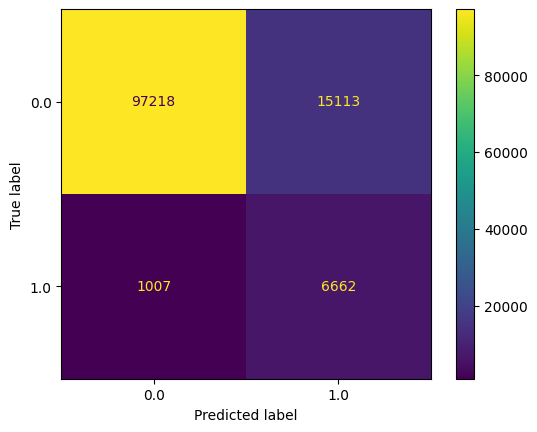

Metrics         Train      Test       Δ         
roc_auc         0.8671     0.8228     -0.0443   
accuracy        0.8657     0.857      -0.0087   
precision       0.3059     0.2794     -0.0265   
recall          0.8687     0.7835     -0.0852   
f1_score        0.4525     0.4119     -0.0406   


Train :
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92    112331
         1.0       0.31      0.87      0.45      7669

    accuracy                           0.87    120000
   macro avg       0.65      0.87      0.69    120000
weighted avg       0.95      0.87      0.89    120000

Test :
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92     28083
         1.0       0.28      0.78      0.41      1917

    accuracy                           0.86     30000
   macro avg       0.63      0.82      0.67     30000
weighted avg       0.94      0.86      0.89     30000

Fit model: LGBMClassifier
Evaluate 

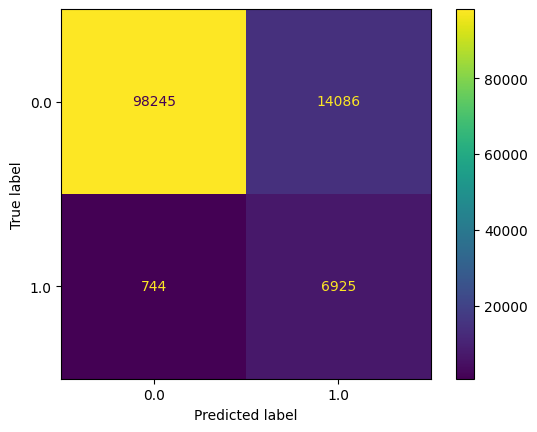

Metrics         Train      Test       Δ         
roc_auc         0.8888     0.8205     -0.0683   
accuracy        0.8764     0.8628     -0.0136   
precision       0.3296     0.2869     -0.0427   
recall          0.903      0.772      -0.131    
f1_score        0.4829     0.4184     -0.0645   


Train :
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    112331
         1.0       0.33      0.90      0.48      7669

    accuracy                           0.88    120000
   macro avg       0.66      0.89      0.71    120000
weighted avg       0.95      0.88      0.90    120000

Test :
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     28083
         1.0       0.29      0.77      0.42      1917

    accuracy                           0.86     30000
   macro avg       0.63      0.82      0.67     30000
weighted avg       0.94      0.86      0.89     30000



In [14]:
# training routine simple
features_number = len(best_features)
test_size = None

# for features_number, estimator in zip((50,), estimators):
for features_number, estimator in zip([50, len(best_features)], estimators):
    # estimator = lgbmc_full
    X_val_stratified_ = X_val_stratified[best_features[:features_number]]
    X_val_stratified_ = X_val_stratified_[:test_size] if test_size else X_val_stratified_
    y_val_stratified_ = y_val_stratified
    y_val_stratified_ = y_val_stratified_[:test_size] if test_size else y_val_stratified_

    print(f'Fit model: {estimator.__class__.__name__}')
    X,y = X_train_stratified[best_features[:features_number]], y_train_stratified
    
    estimator.fit(X, y)

    # evaluate
    print(f'Evaluate {estimator.__class__.__name__}')
    evaluate_model(estimator, X, y, y_val=y_val_stratified_, X_val=X_val_stratified_, is_train=True)



In [167]:
len(best_features)

483

In [43]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
    weight: weight
}
d_train = lgb.Dataset(X_train_stratified[best_features], label=y_train_stratified)
d_val = lgb.Dataset(X_val_stratified[best_features], label=y_val_stratified)

lgbm_full_booster = lgb.train(
    params,
    d_train,
    valid_sets=[d_val],
)

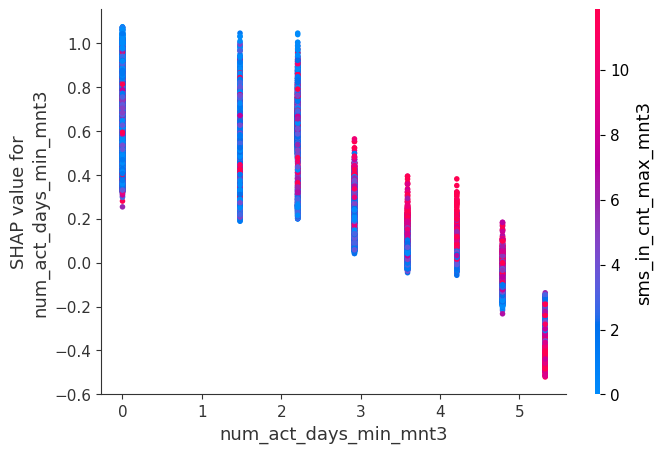

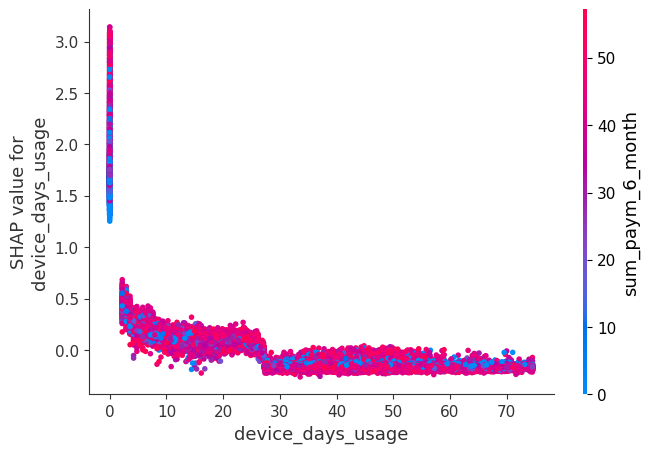

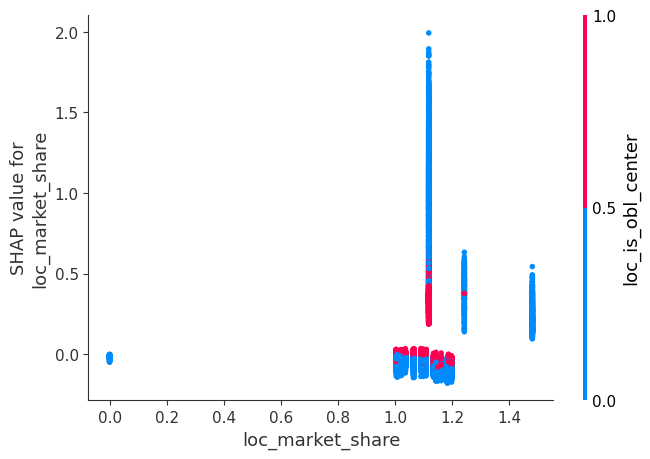

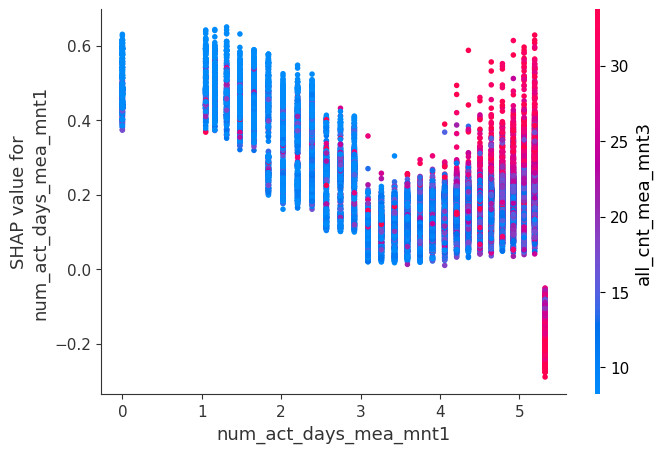

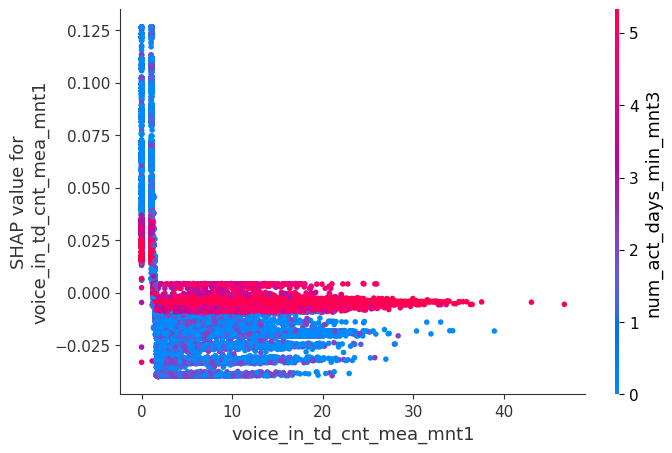

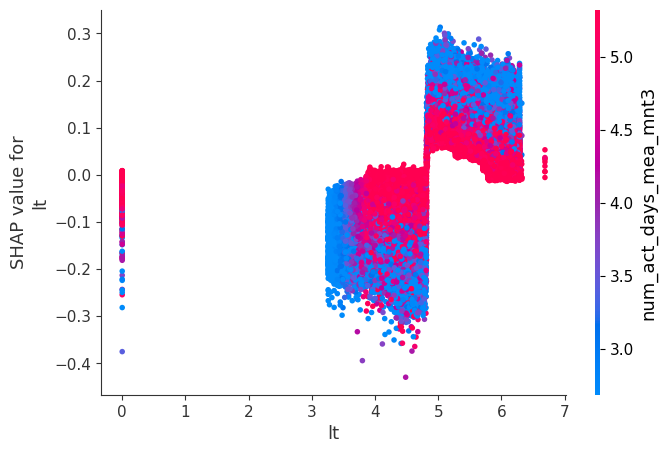

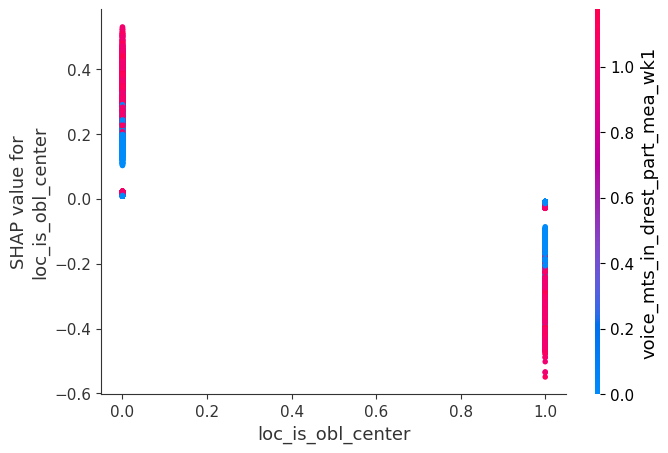

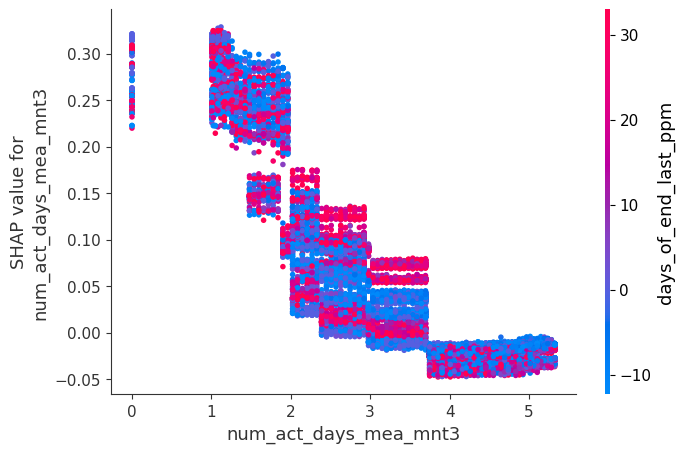

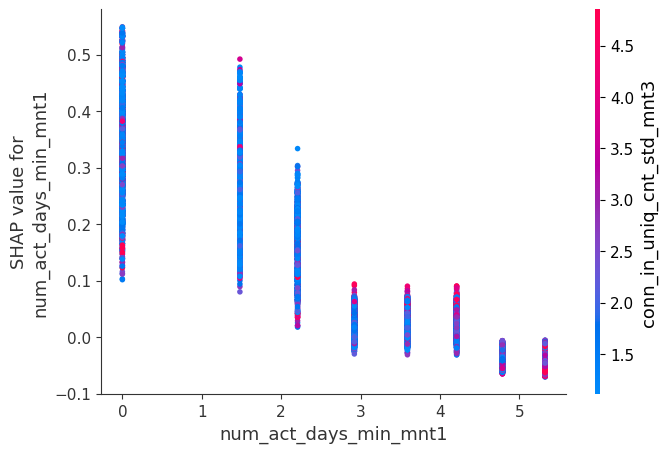

KeyboardInterrupt: 

In [65]:
for name in best_features[:10]:
    shap.dependence_plot(name, shap_values.values, X_train_stratified[best_features])

In [132]:
# for name in best_features[:10]:
#     shap.dependence_plot(name, shap_values.values, X_train_stratified[best_features], interaction_index=None)

In [70]:
shap_values_target  =  lgbm_explainer(X_train_stratified[best_features], y_train_stratified) 

 14%|===                 | 16939/120000 [03:28<21:05]       

In [15]:
X_test, y_test  = prepare_dataset(df_test_fe, df_test_dpi, df_test_bnum, features=best_features)

Accuracy: 0.85666
F1: 0.40432192824490926
Precision: 0.27337779109845645
Recall: 0.7760289269382112
ROC AUC: 0.8190407300324035
AUC: 0.8951227991150188
Classification Report:               precision    recall  f1-score   support

   not churn       0.98      0.86      0.92    140597
       churn       0.27      0.78      0.40      9403

    accuracy                           0.86    150000
   macro avg       0.63      0.82      0.66    150000
weighted avg       0.94      0.86      0.89    150000

ROC Curve: (array([0.        , 0.13794747, 1.        ]), array([0.        , 0.77602893, 1.        ]), array([inf,  1.,  0.]))


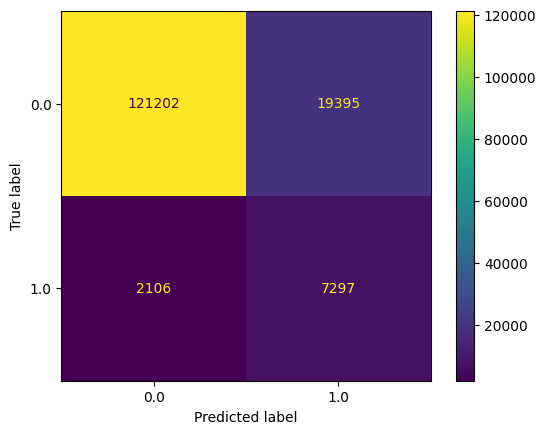

In [16]:
#
evaluate_model(lgbmc, X_test[best_features[:50]], y_test)

Accuracy: 0.4625666666666667
F1: 0.1704995626897155
Precision: 0.09438153607801143
Recall: 0.8811017760289269
ROC AUC: 0.6578385968560462
AUC: 0.7495886460422018
Classification Report:               precision    recall  f1-score   support

   not churn       0.98      0.43      0.60    140597
       churn       0.09      0.88      0.17      9403

    accuracy                           0.46    150000
   macro avg       0.54      0.66      0.39    150000
weighted avg       0.93      0.46      0.58    150000

ROC Curve: (array([0.        , 0.56542458, 1.        ]), array([0.        , 0.88110178, 1.        ]), array([inf,  1.,  0.]))


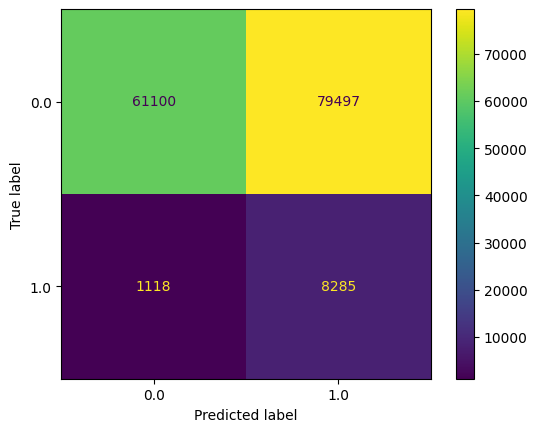

In [149]:
# with scaled device_days_usage 
evaluate_model(lgbmc, X_test[best_features[:50]], y_test)

Accuracy: 0.6234066666666667
F1: 0.19662945317499822
Precision: 0.11349159443131074
Recall: 0.7351908965223865
ROC AUC: 0.6755607675781061
AUC: 0.7518307486787603
Classification Report:               precision    recall  f1-score   support

   not churn       0.97      0.62      0.75    140597
       churn       0.11      0.74      0.20      9403

    accuracy                           0.62    150000
   macro avg       0.54      0.68      0.48    150000
weighted avg       0.92      0.62      0.72    150000

ROC Curve: (array([0.        , 0.38406936, 1.        ]), array([0.       , 0.7351909, 1.       ]), array([inf,  1.,  0.]))


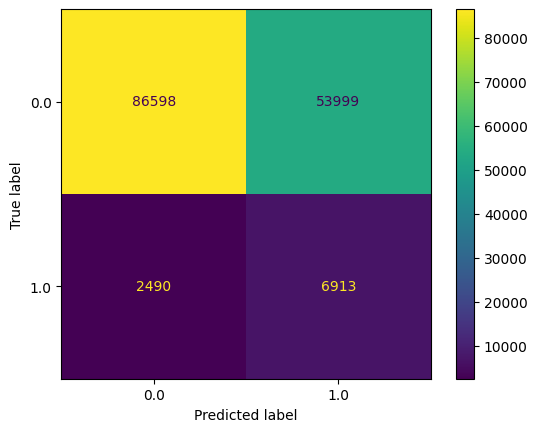

In [148]:
evaluate_model(lgbmc_full, X_test, y_test)

In [19]:
# save model
import joblib
with open('Model/lgbmc_50.pkl', 'wb') as f:
    joblib.dump(lgbmc, f)

with open('Data/lgbmc_full.pkl', 'wb') as f:
    joblib.dump(lgbmc_full, f)

## Explaining model

### there still high rate of FP, let's see what's wrong

In [23]:
X_val = X_val_stratified[best_features[:50]][:1000]
y_val = y_val_stratified[:1000]


In [24]:

y_pred = lgbmc.predict(X_val)

FP = (y_pred == 1) & (y_val == 0)
TP = (y_pred == 1) & (y_val == 1)
TN = (y_pred == 0) & (y_val == 0)
FN = (y_pred == 0) & (y_val == 1)

print(f'FP: {FP.sum()} TP: {TP.sum()} TN: {TN.sum()} FN: {FN.sum()}')

X_FP = X_val[FP]
len(X_FP)
# no scale: FP: 135 TP: 67 TN: 791 FN: 7



FP: 135 TP: 67 TN: 791 FN: 7


135

In [28]:
import shap
lgbmc_50_explainer = shap.TreeExplainer(lgbmc)


In [29]:
shap_values_false_positives = lgbmc_50_explainer.shap_values(X_val)

/Users/andriigerasymchuk/private-repositories/ml-projects/venv/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


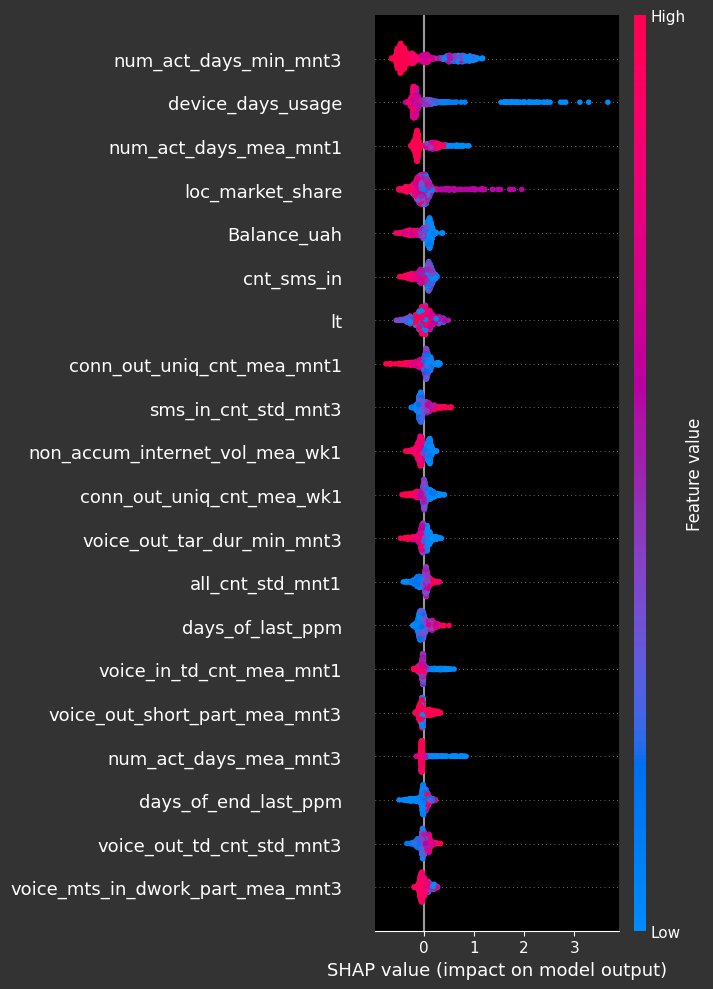

In [48]:
import shap
import matplotlib.pyplot as plt

# Assuming shap_values_false_positives and X_val are already defined

with plt.style.context('dark_background'):
    shap.summary_plot(shap_values_false_positives, X_val, feature_names=X_val.columns, plot_size=(7, 10), show=False)

    # Get the current figure and axes
    fig = plt.gcf()
    ax = plt.gca()

    # Customize the plot for better visibility in dark mode
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    fig.patch.set_alpha(0.8)

    # Customize labels and title
    ax.set_title(ax.get_title(), color='white')
    ax.set_xlabel(ax.get_xlabel(), color='white')
    ax.set_ylabel(ax.get_ylabel(), color='white')

    # Customize tick labels
    ax.tick_params(axis='both', colors='white')

    # Customize the color of feature names
    for text in ax.get_yticklabels():
        text.set_color('white')
        
    # Adjust the legend color if it exists
    legend = ax.get_legend()
    if legend:
        plt.setp(legend.get_texts(), color='white')  # Legend text
        legend.get_frame().set_facecolor('black')   # Legend background
        legend.get_frame().set_edgecolor('white')   # Legend border
    
    plt.show()


IndexError: index 337 is out of bounds for axis 0 with size 135

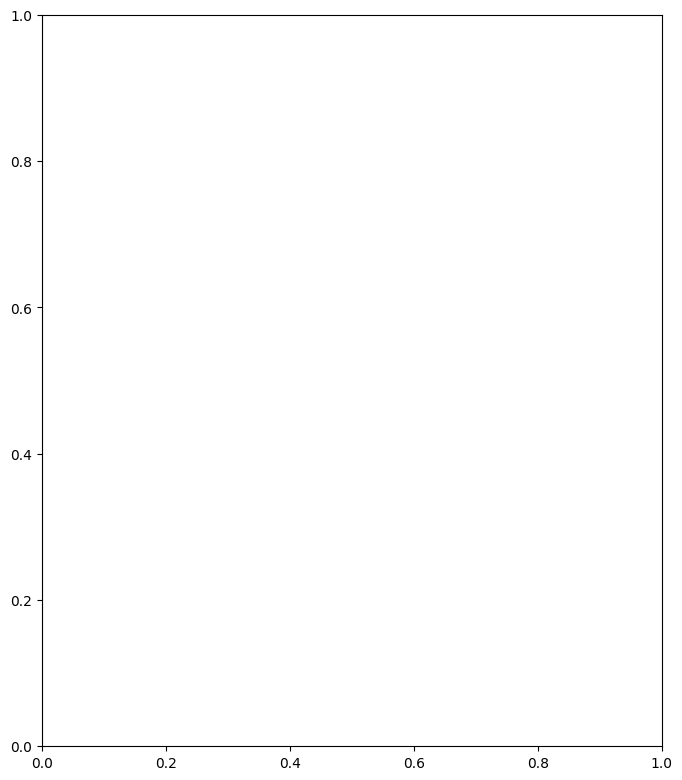

In [ ]:
# Plot summary plot for SHAP values of false positives
shap.summary_plot(shap_values_false_positives, X_FP, feature_names=X_FP.columns)

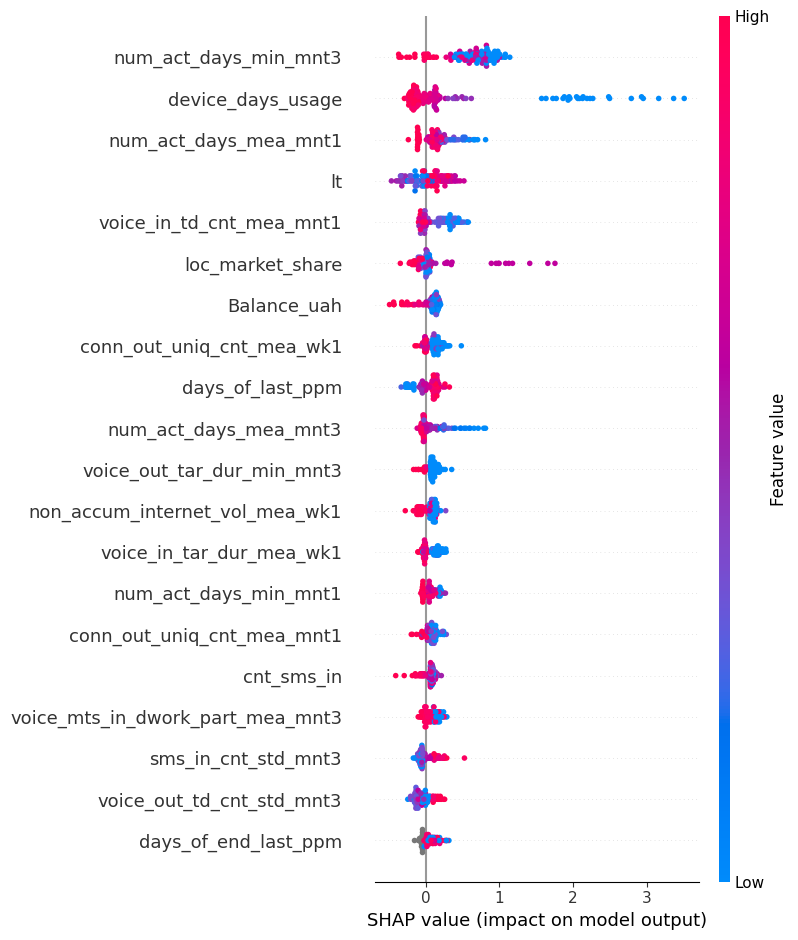

In [156]:
# Scaled days usage
shap.summary_plot(shap_values_false_positives, X_FP, feature_names=X_FP.columns)


### Examine force plot for single prediction:

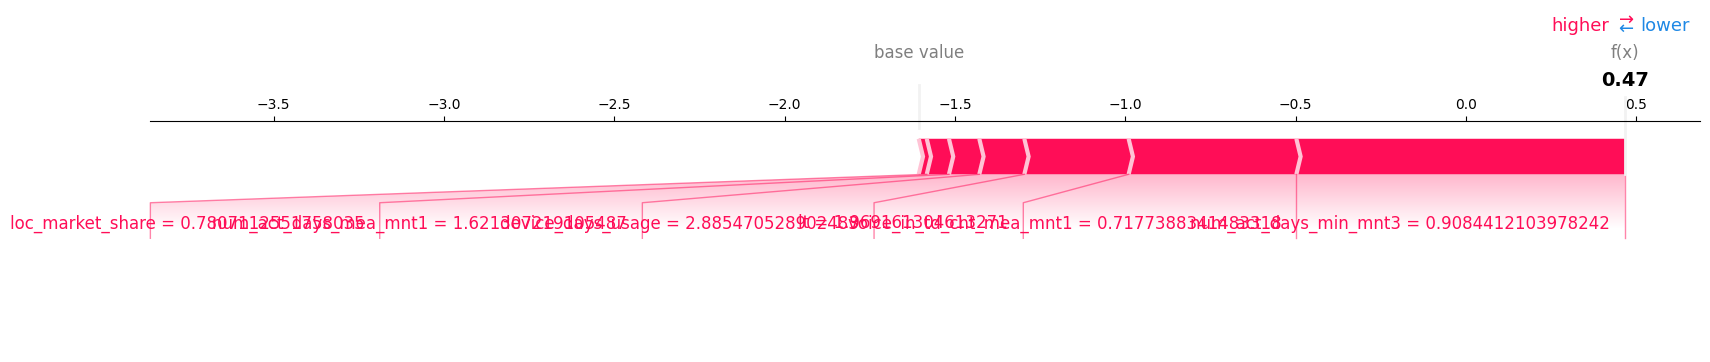

In [157]:
features = X_FP.columns[:7]
# Plot force plot for a single false positive prediction
shap.force_plot(lgbmc_50_explainer.expected_value, shap_values_false_positives[1][:len(features)], X_FP.iloc[1][features], feature_names=features, matplotlib=True, show=True)




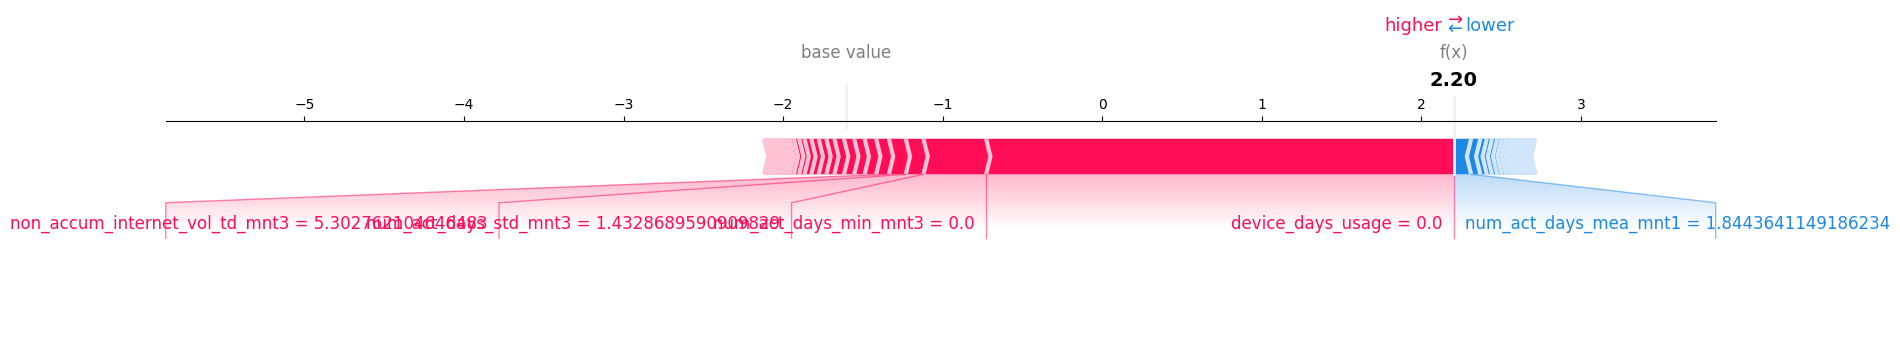

In [158]:

# Plot force plot for a single false positive prediction
shap.force_plot(lgbmc_50_explainer.expected_value, shap_values_false_positives[0], X_FP.iloc[0], feature_names=X_FP.columns, matplotlib=True)


/Users/andriigerasymchuk/private-repositories/ml-projects/venv/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


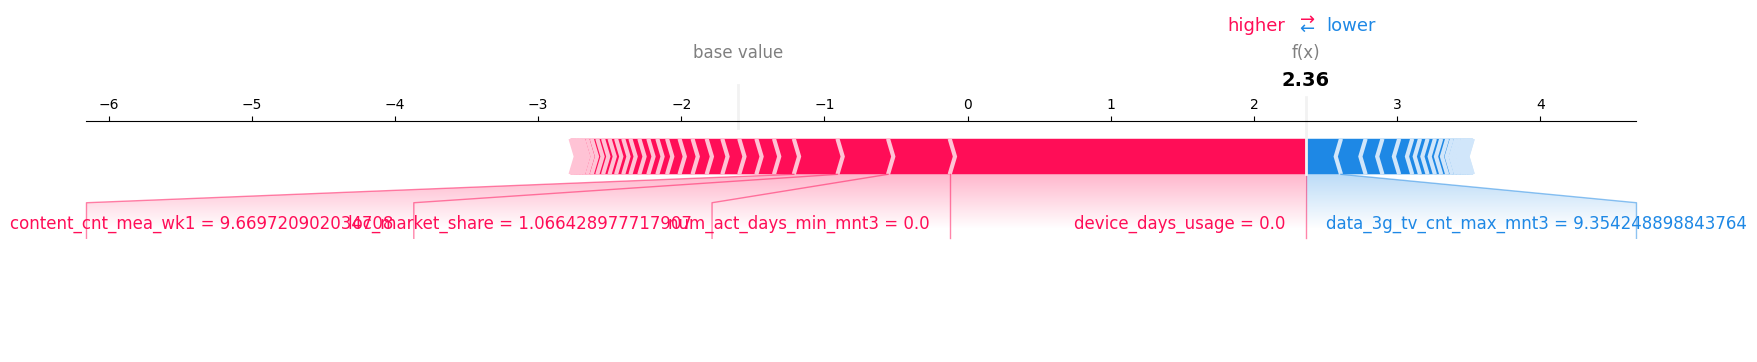

In [128]:
# examine true positive
features = X_val.columns[:7]
X_TP = X_val[TP]
shap_values_true_positives = lgbmc_50_explainer.shap_values(X_TP)
shap.force_plot(lgbmc_50_explainer.expected_value, shap_values_true_positives[0], X_TP.iloc[0], feature_names=X_TP.columns, matplotlib=True)

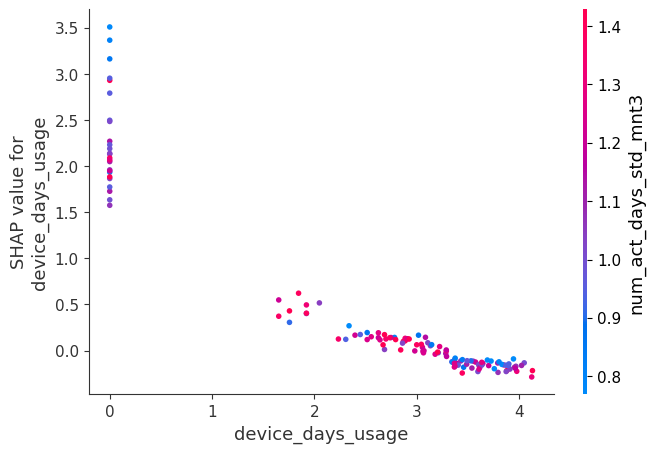

In [159]:

# Plot dependence plot for a specific feature (e.g., feature1) for false positives
shap.dependence_plot('device_days_usage', shap_values_false_positives, X_FP, feature_names=X_FP.columns)


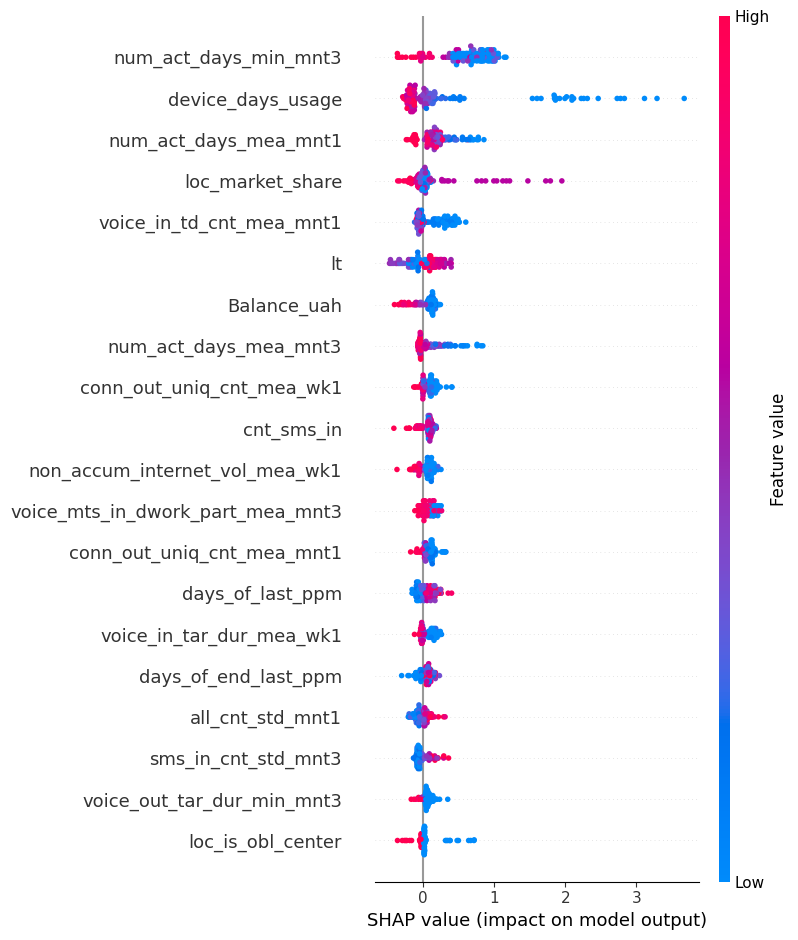

In [174]:
# Plot summary plot for SHAP values of false positives

shap.summary_plot(shap_values_false_positives, X_FP)

In [175]:
shap_values = lgbm_explainer.shap_values(X_val, check_additivity=False)

 18%|====                | 21559/120000 [03:41<16:49]       

In [2]:
# save model
import joblib
with open('Model/lgbmc_50.pkl', 'rb') as f:
    lgbmc = joblib.load(f)


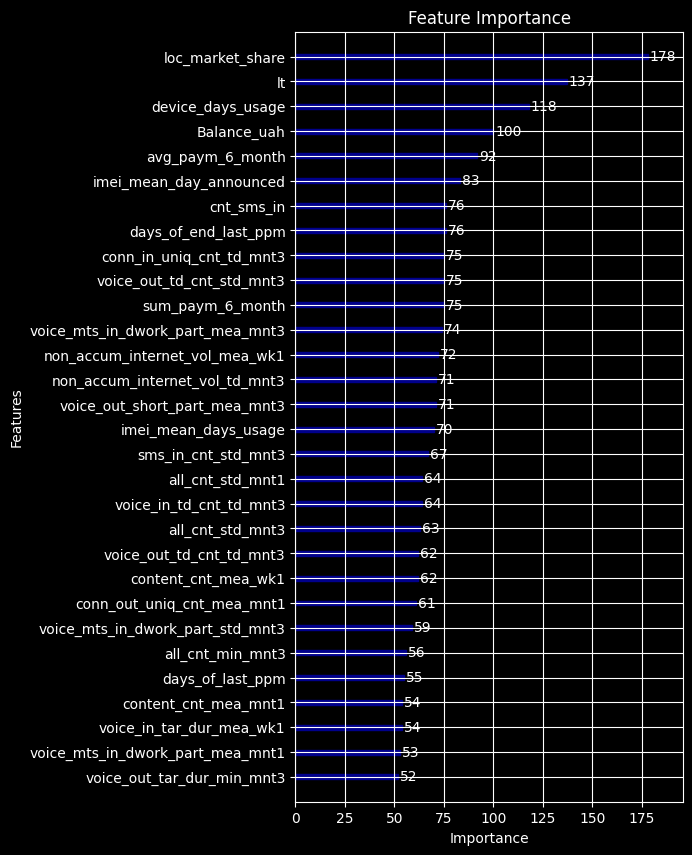

In [38]:
import lightgbm as lgb
import matplotlib.pyplot as plt

with plt.style.context('dark_background'):
    ax = lgb.plot_importance(lgbmc, max_num_features=30, figsize =(5,10), importance_type='split')  # 'split' can be changed to 'gain' to see importance based on information gain
    ax.set_title("Top 50 Feature Importance", color='white')
    ax.set_xlabel("Importance", color='white')
    ax.set_ylabel("Features", color='white')
    ax.tick_params(colors='white', which='both')  # Set color of ticks
    for bar in ax.patches:
        bar.set_color('darkblue') 
    plt.title("Feature Importance")

In [56]:
from catboost import CatBoostClassifier

lgbmc_ = lgb.LGBMClassifier(
            random_state=RANDOM_STATE, 
            metric='auc',
            reg_alpha=0.09,
            scale_pos_weight=weight,
            verbose=-1,
            objective='binary',
            # **params
)
cbc = CatBoostClassifier(**{'iterations': 50, 
        'loss_function': 'Logloss',
        'train_dir': 'crossentropy',
        'verbose': False,
        'eval_metric': 'AUC',
        'allow_writing_files': False,
        'random_seed': RANDOM_STATE}                  
    )
xgbc = xgb.XGBClassifier(
        objective='binary:logistic',
        random_state=RANDOM_STATE
    )



estimators = [
    lgbmc_,
    cbc,
    xgbc,
]

# default metric 0.6780554511967494

Fit model: LGBMClassifier
Evaluate LGBMClassifier
Accuracy: 0.8656666666666667
F1: 0.45252003803831004
Precision: 0.305947187141217
Recall: 0.8686921371756422
ROC AUC: 0.8670761252952305
AUC: 0.945186705062111
Classification Report:               precision    recall  f1-score   support

   not churn       0.99      0.87      0.92    112331
       churn       0.31      0.87      0.45      7669

    accuracy                           0.87    120000
   macro avg       0.65      0.87      0.69    120000
weighted avg       0.95      0.87      0.89    120000

ROC Curve: (array([0.        , 0.13453989, 1.        ]), array([0.        , 0.86869214, 1.        ]), array([inf,  1.,  0.]))


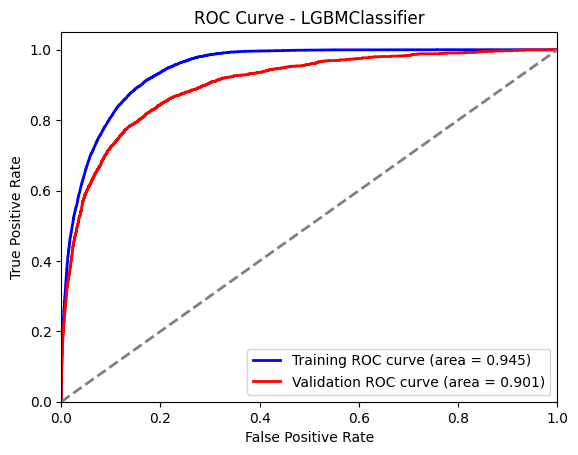

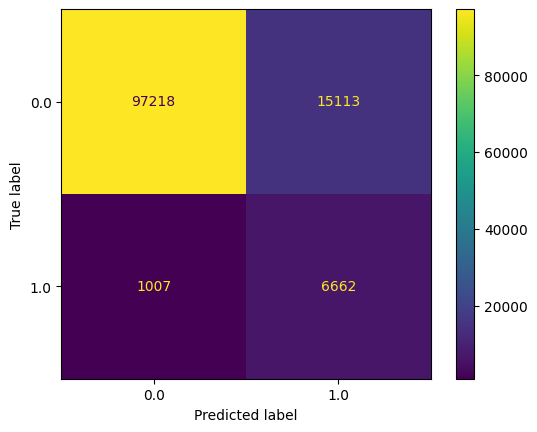

Metrics         Train      Test       Δ         
roc_auc         0.8671     0.8228     -0.0443   
accuracy        0.8657     0.857      -0.0087   
precision       0.3059     0.2794     -0.0265   
recall          0.8687     0.7835     -0.0852   
f1_score        0.4525     0.4119     -0.0406   


Train :
              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92    112331
         1.0       0.31      0.87      0.45      7669

    accuracy                           0.87    120000
   macro avg       0.65      0.87      0.69    120000
weighted avg       0.95      0.87      0.89    120000

Test :
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92     28083
         1.0       0.28      0.78      0.41      1917

    accuracy                           0.86     30000
   macro avg       0.63      0.82      0.67     30000
weighted avg       0.94      0.86      0.89     30000

Fit model: CatBoostClassifier
Evalu

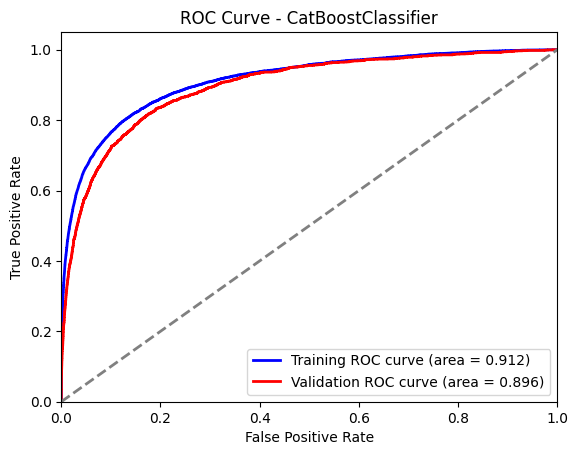

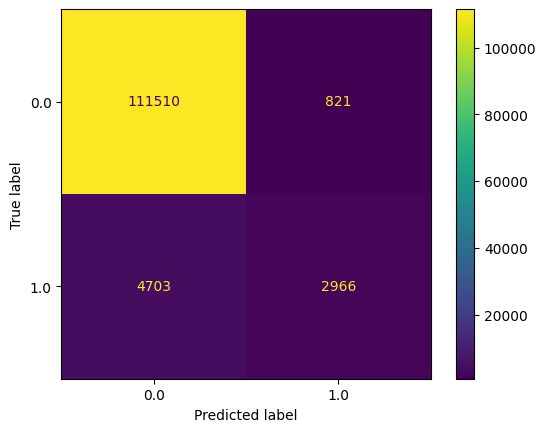

Metrics         Train      Test       Δ         
roc_auc         0.6897     0.6571     -0.0326   
accuracy        0.954      0.9463     -0.0077   
precision       0.7832     0.6617     -0.1215   
recall          0.3868     0.3255     -0.0613   
f1_score        0.5178     0.4364     -0.0814   


Train :
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    112331
         1.0       0.78      0.39      0.52      7669

    accuracy                           0.95    120000
   macro avg       0.87      0.69      0.75    120000
weighted avg       0.95      0.95      0.95    120000

Test :
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     28083
         1.0       0.66      0.33      0.44      1917

    accuracy                           0.95     30000
   macro avg       0.81      0.66      0.70     30000
weighted avg       0.94      0.95      0.94     30000

Fit model: XGBClassifier
Evaluate X

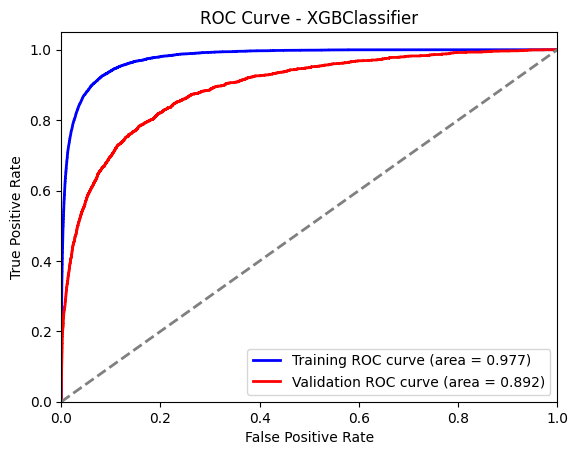

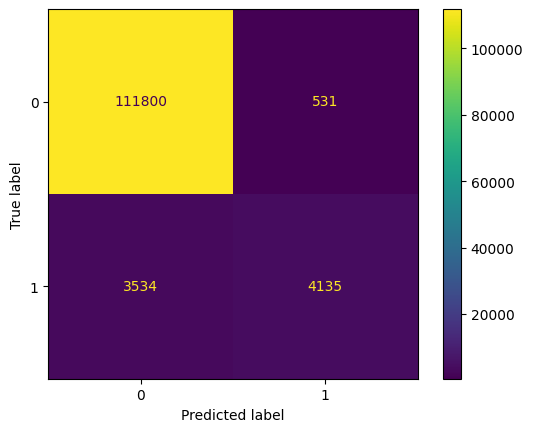

Metrics         Train      Test       Δ         
roc_auc         0.7672     0.6625     -0.1047   
accuracy        0.9661     0.946      -0.0201   
precision       0.8862     0.6496     -0.2366   
recall          0.5392     0.3375     -0.2017   
f1_score        0.6704     0.4442     -0.2262   


Train :
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98    112331
         1.0       0.89      0.54      0.67      7669

    accuracy                           0.97    120000
   macro avg       0.93      0.77      0.83    120000
weighted avg       0.96      0.97      0.96    120000

Test :
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     28083
         1.0       0.65      0.34      0.44      1917

    accuracy                           0.95     30000
   macro avg       0.80      0.66      0.71     30000
weighted avg       0.94      0.95      0.94     30000



In [57]:
# training routine simple
features_number = len(best_features)
test_size = None

# for features_number, estimator in zip((50,), estimators):
for features_number, estimator in zip([50, 50,  50], estimators):
    # estimator = lgbmc_full
    X_val_stratified_ = X_val_stratified[best_features[:features_number]]
    X_val_stratified_ = X_val_stratified_[:test_size] if test_size else X_val_stratified_
    y_val_stratified_ = y_val_stratified
    y_val_stratified_ = y_val_stratified_[:test_size] if test_size else y_val_stratified_

    print(f'Fit model: {estimator.__class__.__name__}')
    X,y = X_train_stratified[best_features[:features_number]], y_train_stratified
    
    estimator.fit(X, y)

    # evaluate
    print(f'Evaluate {estimator.__class__.__name__}')
    evaluate_model(estimator, X, y, y_val=y_val_stratified_, X_val=X_val_stratified_, is_train=True)



In [58]:
estimators

[LGBMClassifier(metric='auc', objective='binary', random_state=42,
                reg_alpha=0.09, scale_pos_weight=14, verbose=-1),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...)]

In [63]:
# Voting
from sklearn.ensemble import VotingClassifier

ensemble_full = VotingClassifier(
    estimators=list(zip([s.__class__.__name__ for s in estimators], estimators)), voting='soft')


In [65]:
X_train_sX_train_stratified[best_features[:50]
ensemble_full.fit(X_train_stratified[best_features[:50]], y_train_stratified)


VotingClassifier(estimators=[('LGBMClassifier',
                              LGBMClassifier(metric='auc', objective='binary',
                                             random_state=42, reg_alpha=0.09,
                                             scale_pos_weight=14, verbose=-1)),
                             ('CatBoostClassifier',
                              <catboost.core.CatBoostClassifier object at 0x13799d410>),
                             ('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

Fit model: VotingClassifier
Evaluate VotingClassifier
Accuracy: 0.9590166666666666
F1: 0.6543921293042867
Precision: 0.7096479195244627
Recall: 0.6071195723040813
ROC AUC: 0.7950803815353276
AUC: 0.9604721002950178
Classification Report:               precision    recall  f1-score   support

   not churn       0.97      0.98      0.98    112331
       churn       0.71      0.61      0.65      7669

    accuracy                           0.96    120000
   macro avg       0.84      0.80      0.82    120000
weighted avg       0.96      0.96      0.96    120000

ROC Curve: (array([0.        , 0.01695881, 1.        ]), array([0.        , 0.60711957, 1.        ]), array([inf,  1.,  0.]))


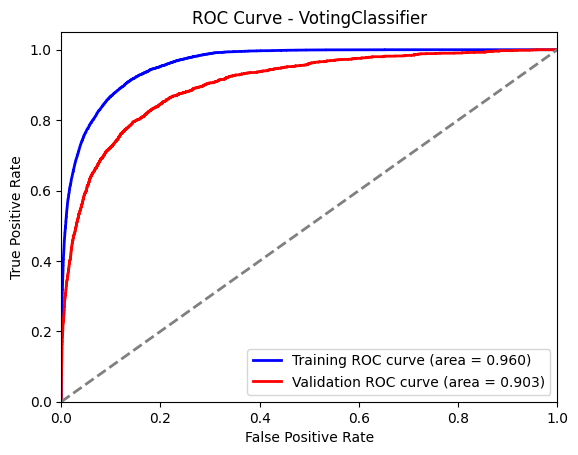

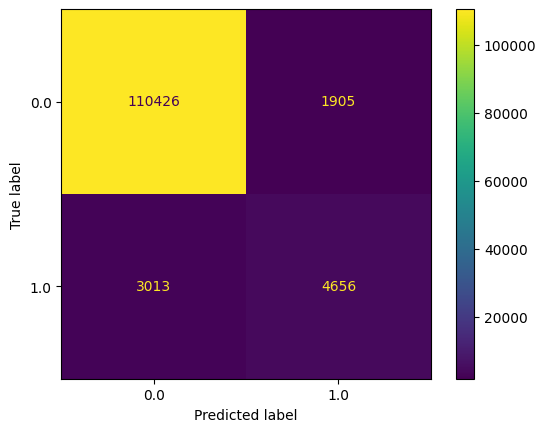

Metrics         Train      Test       Δ         
roc_auc         0.7951     0.7234     -0.0717   
accuracy        0.959      0.9427     -0.0163   
precision       0.7096     0.5611     -0.1485   
recall          0.6071     0.4721     -0.135    
f1_score        0.6544     0.5127     -0.1417   


Train :
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98    112331
         1.0       0.71      0.61      0.65      7669

    accuracy                           0.96    120000
   macro avg       0.84      0.80      0.82    120000
weighted avg       0.96      0.96      0.96    120000

Test :
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     28083
         1.0       0.56      0.47      0.51      1917

    accuracy                           0.94     30000
   macro avg       0.76      0.72      0.74     30000
weighted avg       0.94      0.94      0.94     30000



In [70]:
# training routine simple
features_number = len(best_features)
test_size = None

# for features_number, estimator in zip((50,), estimators):
for features_number, estimator in zip([50], [ensemble_full]):
    # estimator = lgbmc_full
    X_val_stratified_ = X_val_stratified[best_features[:features_number]]
    X_val_stratified_ = X_val_stratified_[:test_size] if test_size else X_val_stratified_
    y_val_stratified_ = y_val_stratified
    y_val_stratified_ = y_val_stratified_[:test_size] if test_size else y_val_stratified_

    print(f'Fit model: {estimator.__class__.__name__}')
    X,y = X_train_stratified[best_features[:features_number]], y_train_stratified
    
    estimator.fit(X, y)

    # evaluate
    print(f'Evaluate {estimator.__class__.__name__}')
    evaluate_model(estimator, X, y, y_val=y_val_stratified_, X_val=X_val_stratified_, is_train=True)



In [72]:
# save model
import joblib
with open('Model/ensemble_50.pkl', 'wb') as f:
    joblib.dump(ensemble_full, f)